## Fitting super novae data

In this notebook we will perform a simplified version of the Supernovae cosmological data analysis.

We will use Supernovae data from Joint Likecurve Analysis (http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html).

In [1]:
from __future__ import print_function
%matplotlib inline
import scipy as sp
from scipy.interpolate import interp1d
from scipy.linalg import inv
import iminuit
from matplotlib.pyplot import errorbar, plot, contour, hist2d, grid, hist
from scipy import random
import emcee
import corner

In an older version of this notebook we used older data from the Supernova Union sample (http://supernova.lbl.gov/). If we want to use the older data, set the `useUnionData` flag to `True`.

<Container object of 3 artists>

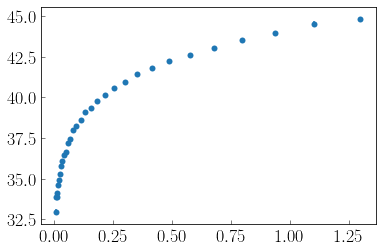

In [13]:
useUnionData = False
if useUnionData:
    data=sp.loadtxt('data/SCPUnion2.1_mu_vs_z.txt',usecols=(1,2,3))
    z = data[:,0]
    M = data[:,1]
    dM = data[:,2]
    
    ## We will sort the redshifts. This is only useful for making plots:
    s = z.argsort()
    z = z[s]
    M = M[s]
    dM = dM[s]
    icov = sp.diag(1/dM**2)
else:
    data = sp.loadtxt('data/jla_mub.txt')
    z = data[:,0]
    M = data[:,1]
    ## the JLA data has full covariance information.
    ## we will use it in this notebook
    cov = sp.loadtxt('data/jla_mub_covmatrix.dat', skiprows=1)
    cov = cov.reshape((len(z), len(z)))
    ## the chi2 requires the inverse covariance:
    icov = inv(cov)
    dM = sp.sqrt(cov.diagonal())
## plot data:
errorbar(z, M, yerr = dM, fmt = "o")

In [14]:
def hubble(z, H0, Om, OL):
    H = H0*sp.sqrt(Om*(1+z)**3 + OL + (1-Om-OL)*(1+z)**2)
    return H

In [15]:
nbins=10000
zmax = 2.
zs = sp.arange(nbins, dtype=float)/(nbins-1)*zmax
dz = zmax/nbins
c = 300000. ## km/s
def D_L(H0, Om, OL):
    chi = (dz*H0/hubble(zs, H0, Om, OL)).cumsum()
    chi = interp1d(zs, chi)(z)
    Ok = 1-Om-OL
    if Ok==0:
        return c/H0*(1+z)*chi
    if Ok > 0:
        return c/H0*(1+z)*sp.sinh(sp.sqrt(Ok)*chi)/sp.sqrt(Ok)
    if Ok<0:
        return c/H0*(1+z)*sp.sin(sp.sqrt(-Ok)*chi)/sp.sqrt(-Ok)
    

In [16]:
## distance modulus
def mu(H0, Om, OL):
    d_pc = D_L(H0, Om, OL)*1e6
    return 5*sp.log10(d_pc)-5

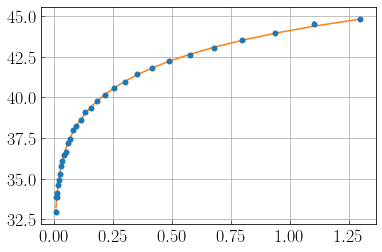

In [17]:
errorbar(z, M, yerr = dM, fmt = "o")
plot(z, mu(70., 0.3, 0.7))
grid()

In [18]:
def chi2(H0, Om, OL):
    res = (M - mu(H0, Om, OL))
    return res.dot(icov.dot(res))

In [19]:
mig = iminuit.Minuit(chi2, H0=70., Om=0.3, 
        OL=0.7, error_H0=1, error_Om=0.1, error_OL=0.1,
        errordef=1)

In [20]:
fmin = mig.migrad()
print("Number of data points: ",len(M))

FCN = 35.4784638414 
 TOTAL NCALL = 61 
 NCALLS = 61 
 
 
 EDM = 2.12118003293e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,H0,70.2244,0.821806,0,0,,,
2,Om,0.224264,0.108244,0,0,,,
3,OL,0.628539,0.160597,0,0,,,


Number of data points:  31


In [21]:
nOm = 40
Om = 0.5*sp.arange(nOm, dtype=float)/(nOm-1)
nOL = 40
OL = 0.2+1.*sp.arange(nOL, dtype=float)/(nOL-1)
chi2_scan = sp.zeros((nOL, nOm))
for i in range(nOm):
    print('\rdoing chi2 scan {}%'.format(round(i*100./nOm,2)), end='')
    for j in range(nOL):
        H2 = Om[i]*(1+zs)**3 + OL[j] + (1-Om[i]-OL[j])*(1+zs)**2
        if (H2<=0).any():
            chi2_scan[j, i] = sp.inf
            continue
        mig_scan = iminuit.Minuit(chi2, H0=70., Om=Om[i], 
        OL=OL[j], error_H0=1, error_Om=0.1, error_OL=0.1,
        errordef=1, fix_Om=True, fix_OL=True, print_level=0, limit_H0 = (0, None))
        mig_scan.migrad()
        chi2_scan[j, i] = mig_scan.fval-mig.fval
print('\ndone')

doing chi2 scan 97.5%
done


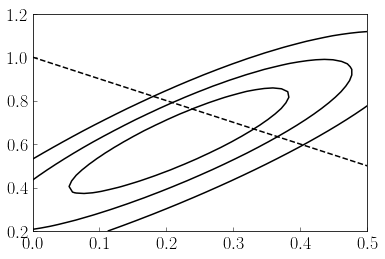

In [22]:
#contourf(Om, OL, sp.log10(chi2_scan))
#colorbar()
contour(Om, OL, chi2_scan, levels=[2.3, 6., 11.8], colors="k")
plot(Om,1-Om,"k--")

In [23]:
## This MC generates data ignoring the full covariance.
NMC = 500
Om_mc = sp.zeros(NMC)
OL_mc = sp.zeros(NMC)
mig_mc = iminuit.Minuit(chi2, H0=70., Om=0.3, 
        OL=0.7, error_H0=1, error_Om=0.1, error_OL=0.1,
        errordef=1, print_level=0)
for i in range(NMC):
    ## get the distance modulus for the best fit parameters
    M = mu(mig.values['H0'], mig.values['Om'], mig.values['OL'])
    M += dM*random.randn(len(M))
    fmin = mig_mc.migrad()
    print("\riteration: {} of {}, Om: {}, OL: {}".format(i, NMC, mig_mc.values['Om'], mig_mc.values['OL']), end='')
    Om_mc[i] = mig_mc.values['Om']
    OL_mc[i] = mig_mc.values['OL']
    

iteration: 499 of 500, Om: 0.260732990387, OL: 0.608535894525

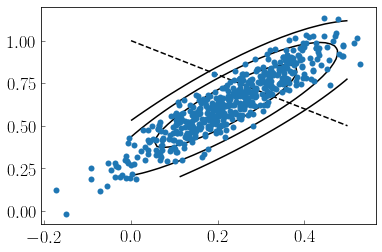

In [25]:
contour(Om, OL, chi2_scan, levels=[2.3, 6, 11.8], colors="k")
plot(Om,1-Om,"k--")
plot(Om_mc, OL_mc, "o")

In [28]:
## We overrode the data when generating the MC samples
## We need to read it again
if useUnionData:
    data=sp.loadtxt('data/SCPUnion2.1_mu_vs_z.txt',usecols=(1,2,3))
    z = data[:,0]
    M = data[:,1]
    dM = data[:,2]
    icov = sp.diag(1/dM**2)
else:
    data = sp.loadtxt('data/jla_mub.txt')
    z = data[:,0]
    M = data[:,1]
    cov = sp.loadtxt('data/jla_mub_covmatrix.dat', skiprows=1)
    cov = cov.reshape((len(z), len(z)))
    icov = inv(cov)

In [29]:
def lnprob(pars):
    H0 = pars[0]
    Om = pars[1]
    OL = pars[2]
    if H0<0:
        return -sp.inf
    H2 = H0**2*(Om*(1+z)**2 + OL + (1-Om-OL)*(1+z)**2)
    if (H2<0).any():
        return -sp.inf
    
    return -0.5*chi2(H0, Om, OL)

In [30]:
ndim, nwalkers = 3, 50
Om0 = 0.3 + 0.01*random.randn(nwalkers)
OL0 = 0.7 + 0.01*random.randn(nwalkers)
H0 = 70. + 0.01*random.rand(nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [31]:
pos, prob, state = sampler.run_mcmc(sp.array([H0, Om0, OL0]).T, 500)

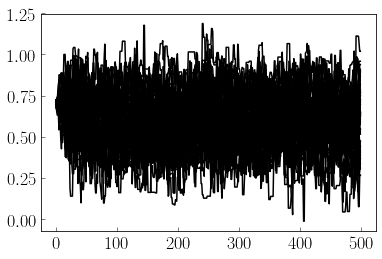

In [32]:
for i in range(nwalkers):
    plot(sampler.chain[i,:,2],"k")

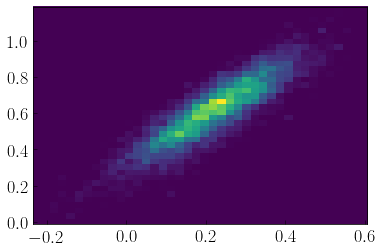

In [33]:
_=hist2d(sampler.chain[:,100:,1].flatten(), sampler.chain[:,100:,2].flatten(), bins=40)

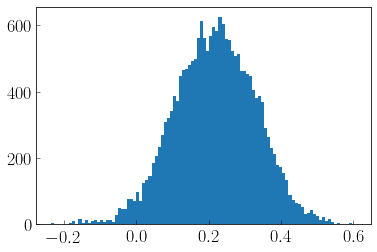

In [34]:
_=hist(sampler.chain[:,100:,1].flatten(), bins=100)

In [35]:
samples = sampler.chain[:,100:,:].reshape([-1, ndim])

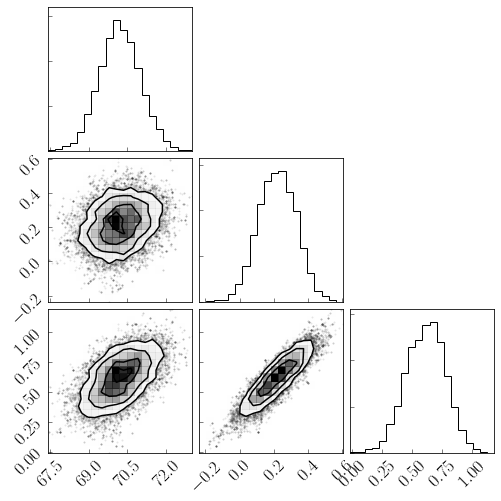

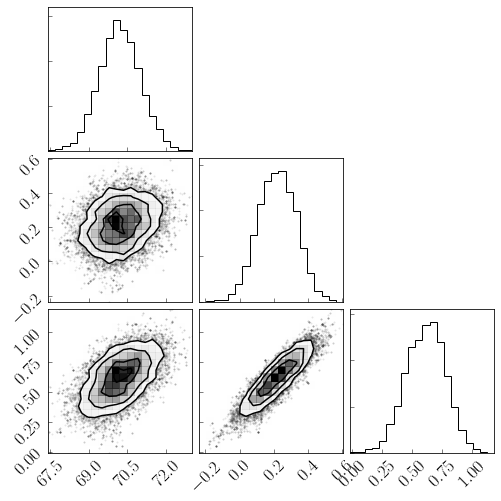

In [36]:
corner.corner(samples[:,:])

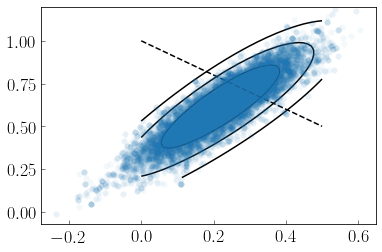

In [37]:
contour(Om, OL, chi2_scan, levels=[2.3, 6, 11.8], colors="k")
plot(Om,1-Om,"k--")
plot(samples[:,1], samples[:,2], "o", alpha=0.05)